# Estimation and Statistical Validation

This notebook demonstrates the comprehensive estimation capabilities of the LRDBenchmark library, covering all available estimator categories with statistical validation.

## Overview

Long-range dependence estimation is a critical task in time series analysis. This notebook covers:

1. **Estimator Categories**: Classical, Machine Learning, and Neural Network estimators
2. **Statistical Validation**: Confidence intervals, bootstrap methods, convergence analysis
3. **Performance Comparison**: Accuracy, speed, and robustness across different estimators
4. **Decision Guidelines**: When to use which estimator

## Table of Contents

1. [Setup and Imports](#setup)
2. [Estimator Categories Overview](#overview)
3. [Classical Estimators](#classical)
4. [Machine Learning Estimators](#ml)
5. [Neural Network Estimators](#neural)
6. [Statistical Validation](#validation)
7. [Performance Comparison](#comparison)
8. [Decision Guidelines](#guidelines)
9. [Summary and Next Steps](#summary)


## 1. Setup and Imports {#setup}

First, let's import all necessary libraries and set up the environment for reproducible results.


In [1]:
# Standard scientific computing imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import bootstrap
import time
import warnings
warnings.filterwarnings('ignore')

# Set JAX to use CPU to avoid CUDA issues
import os
os.environ['JAX_PLATFORMS'] = 'cpu'

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Set random seed for reproducibility
np.random.seed(42)

# Import LRDBenchmark data models
from lrdbenchmark.models.data_models.fbm.fbm_model import FractionalBrownianMotion
from lrdbenchmark.models.data_models.fgn.fgn_model import FractionalGaussianNoise

# Import Classical estimators
from lrdbenchmark.analysis.temporal.rs.rs_estimator_unified import RSEstimator
from lrdbenchmark.analysis.temporal.dfa.dfa_estimator_unified import DFAEstimator
from lrdbenchmark.analysis.temporal.dma.dma_estimator_unified import DMAEstimator
from lrdbenchmark.analysis.temporal.higuchi.higuchi_estimator_unified import HiguchiEstimator
from lrdbenchmark.analysis.spectral.gph.gph_estimator_unified import GPHEstimator
from lrdbenchmark.analysis.spectral.whittle.whittle_estimator_unified import WhittleEstimator
from lrdbenchmark.analysis.spectral.periodogram.periodogram_estimator_unified import PeriodogramEstimator

# Import ML estimators
from lrdbenchmark.analysis.machine_learning.random_forest_estimator_unified import RandomForestEstimator
from lrdbenchmark.analysis.machine_learning.svr_estimator_unified import SVREstimator
from lrdbenchmark.analysis.machine_learning.gradient_boosting_estimator_unified import GradientBoostingEstimator

# Import Neural Network estimators
from lrdbenchmark.analysis.machine_learning.cnn_estimator_unified import CNNEstimator
from lrdbenchmark.analysis.machine_learning.lstm_estimator_unified import LSTMEstimator
from lrdbenchmark.analysis.machine_learning.gru_estimator_unified import GRUEstimator
from lrdbenchmark.analysis.machine_learning.transformer_estimator_unified import TransformerEstimator

print("✅ All imports successful!")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")


✅ All imports successful!
NumPy version: 2.3.3
Pandas version: 2.3.3


## 2. Estimator Categories Overview {#overview}

LRDBenchmark provides three main categories of Hurst parameter estimators:

### 1. Classical Estimators
- **Temporal**: R/S Analysis, DFA, DMA, Higuchi
- **Spectral**: GPH, Whittle, Periodogram
- **Wavelet**: CWT, Wavelet Variance, Log Variance, Wavelet Whittle
- **Multifractal**: MFDFA, Wavelet Leaders

### 2. Machine Learning Estimators
- **Random Forest**: Ensemble tree-based estimation
- **Support Vector Regression**: SVM-based estimation
- **Gradient Boosting**: Boosted tree estimation

### 3. Neural Network Estimators
- **CNN**: Convolutional Neural Networks
- **LSTM**: Long Short-Term Memory networks
- **GRU**: Gated Recurrent Units
- **Transformer**: Attention-based architectures

Let's demonstrate each category with comprehensive examples.


## 3. Classical Estimators {#classical}

Classical estimators are based on well-established statistical methods for LRD estimation. They are fast, interpretable, and have strong theoretical foundations.


In [2]:
# Generate test data with known Hurst parameters
print("🔍 Generating test data for classical estimator evaluation...")

# Test with different Hurst parameters
H_values = [0.3, 0.5, 0.7, 0.9]
n_samples = 1000

# Generate FBM data for each H value
test_data = {}
for H in H_values:
    fbm = FractionalBrownianMotion(H=H, sigma=1.0)
    data = fbm.generate(n_samples, seed=42)
    test_data[f'H={H}'] = {'data': data, 'true_H': H}

print(f"Generated {len(test_data)} test datasets")

# Initialize classical estimators
classical_estimators = {
    'R/S Analysis': RSEstimator(),
    'DFA': DFAEstimator(),
    'DMA': DMAEstimator(),
    'Higuchi': HiguchiEstimator(),
    'GPH': GPHEstimator(),
    'Whittle': WhittleEstimator(),
    'Periodogram': PeriodogramEstimator()
}

print(f"Initialized {len(classical_estimators)} classical estimators")

# Test classical estimators
print("\n📊 Classical Estimator Results:")
print("=" * 60)

results = []

for data_name, data_info in test_data.items():
    data = data_info['data']
    true_H = data_info['true_H']
    
    print(f"\n{data_name} (True H = {true_H}):")
    print("-" * 40)
    
    for estimator_name, estimator in classical_estimators.items():
        try:
            start_time = time.time()
            result = estimator.estimate(data)
            end_time = time.time()
            
            if isinstance(result, dict):
                estimated_H = result.get('hurst_parameter', result.get('H', None))
            else:
                estimated_H = result
            
            if estimated_H is not None:
                error = abs(estimated_H - true_H)
                execution_time = end_time - start_time
                
                print(f"  {estimator_name:12}: H = {estimated_H:.4f}, Error = {error:.4f}, Time = {execution_time:.3f}s")
                
                results.append({
                    'Data': data_name,
                    'True_H': true_H,
                    'Estimator': estimator_name,
                    'Estimated_H': estimated_H,
                    'Error': error,
                    'Execution_Time': execution_time,
                    'Category': 'Classical'
                })
            else:
                print(f"  {estimator_name:12}: Failed to estimate")
                
        except Exception as e:
            print(f"  {estimator_name:12}: Error - {str(e)[:50]}...")

# Create results DataFrame
results_df = pd.DataFrame(results)
print(f"\n📈 Summary: {len(results_df)} successful estimations")

# Calculate performance metrics
if len(results_df) > 0:
    performance_summary = results_df.groupby('Estimator').agg({
        'Error': ['mean', 'std', 'min', 'max'],
        'Execution_Time': ['mean', 'std']
    }).round(4)
    
    print("\n📊 Performance Summary (Classical Estimators):")
    print(performance_summary)


🔍 Generating test data for classical estimator evaluation...
Generated 4 test datasets
Initialized 7 classical estimators

📊 Classical Estimator Results:

H=0.3 (True H = 0.3):
----------------------------------------
  R/S Analysis: H = 0.1686, Error = 0.1314, Time = 1.818s
  DFA         : H = 0.0206, Error = 0.2794, Time = 0.008s
  DMA         : H = 0.0158, Error = 0.2842, Time = 0.001s
  Higuchi     : H = 0.0000, Error = 0.3000, Time = 0.002s
  GPH         : H = 0.9900, Error = 0.6900, Time = 0.285s
  Whittle     : H = 0.7000, Error = 0.4000, Time = 0.001s
  Periodogram : H = 0.9900, Error = 0.6900, Time = 0.001s

H=0.5 (True H = 0.5):
----------------------------------------
  R/S Analysis: H = 0.5907, Error = 0.0907, Time = 0.026s
  DFA         : H = 0.5266, Error = 0.0266, Time = 0.007s
  DMA         : H = 0.6596, Error = 0.1596, Time = 0.001s
  Higuchi     : H = 0.5288, Error = 0.0288, Time = 0.002s
  GPH         : H = 0.6064, Error = 0.1064, Time = 0.001s
  Whittle     : H = 0.

## 4. Machine Learning Estimators {#ml}

Machine Learning estimators use pre-trained models to estimate Hurst parameters. They are particularly useful for complex time series patterns and can handle non-standard LRD processes.


In [3]:
# Test ML estimators
print("\n🤖 Machine Learning Estimator Results:")
print("=" * 60)

ml_estimators = {
    'Random Forest': RandomForestEstimator(),
    'SVR': SVREstimator(),
    'Gradient Boosting': GradientBoostingEstimator()
}

for data_name, data_info in test_data.items():
    data = data_info['data']
    true_H = data_info['true_H']
    
    print(f"\n{data_name} (True H = {true_H}):")
    print("-" * 40)
    
    for estimator_name, estimator in ml_estimators.items():
        try:
            start_time = time.time()
            result = estimator.estimate(data)
            end_time = time.time()
            
            if isinstance(result, dict):
                estimated_H = result.get('hurst_parameter', result.get('H', None))
            else:
                estimated_H = result
            
            if estimated_H is not None:
                error = abs(estimated_H - true_H)
                execution_time = end_time - start_time
                
                print(f"  {estimator_name:15}: H = {estimated_H:.4f}, Error = {error:.4f}, Time = {execution_time:.3f}s")
                
                results.append({
                    'Data': data_name,
                    'True_H': true_H,
                    'Estimator': estimator_name,
                    'Estimated_H': estimated_H,
                    'Error': error,
                    'Execution_Time': execution_time,
                    'Category': 'ML'
                })
            else:
                print(f"  {estimator_name:15}: Failed to estimate")
                
        except Exception as e:
            print(f"  {estimator_name:15}: Error - {str(e)[:50]}...")



🤖 Machine Learning Estimator Results:

H=0.3 (True H = 0.3):
----------------------------------------
  Random Forest  : H = 0.4751, Error = 0.1751, Time = 0.197s
  SVR            : H = 0.6080, Error = 0.3080, Time = 0.023s
  Gradient Boosting: H = 0.4742, Error = 0.1742, Time = 0.014s

H=0.5 (True H = 0.5):
----------------------------------------
  Random Forest  : H = 0.4826, Error = 0.0174, Time = 0.024s
  SVR            : H = 0.6080, Error = 0.1080, Time = 0.013s
  Gradient Boosting: H = 0.5665, Error = 0.0665, Time = 0.013s

H=0.7 (True H = 0.7):
----------------------------------------
  Random Forest  : H = 0.4991, Error = 0.2009, Time = 0.027s
  SVR            : H = 0.6080, Error = 0.0920, Time = 0.012s
  Gradient Boosting: H = 0.5557, Error = 0.1443, Time = 0.012s

H=0.9 (True H = 0.9):
----------------------------------------
  Random Forest  : H = 0.5054, Error = 0.3946, Time = 0.023s
  SVR            : H = 0.6080, Error = 0.2920, Time = 0.011s
  Gradient Boosting: H = 0.4

## 5. Neural Network Estimators {#neural}

Neural Network estimators use deep learning models to estimate Hurst parameters. They can capture complex non-linear patterns and are particularly effective for high-dimensional time series.


In [4]:
# Test Neural Network estimators
print("\n🧠 Neural Network Estimator Results:")
print("=" * 60)

neural_estimators = {
    'CNN': CNNEstimator(),
    'LSTM': LSTMEstimator(),
    'GRU': GRUEstimator(),
    'Transformer': TransformerEstimator()
}

for data_name, data_info in test_data.items():
    data = data_info['data']
    true_H = data_info['true_H']
    
    print(f"\n{data_name} (True H = {true_H}):")
    print("-" * 40)
    
    for estimator_name, estimator in neural_estimators.items():
        try:
            start_time = time.time()
            result = estimator.estimate(data)
            end_time = time.time()
            
            if isinstance(result, dict):
                estimated_H = result.get('hurst_parameter', result.get('H', None))
            else:
                estimated_H = result
            
            if estimated_H is not None:
                error = abs(estimated_H - true_H)
                execution_time = end_time - start_time
                
                print(f"  {estimator_name:12}: H = {estimated_H:.4f}, Error = {error:.4f}, Time = {execution_time:.3f}s")
                
                results.append({
                    'Data': data_name,
                    'True_H': true_H,
                    'Estimator': estimator_name,
                    'Estimated_H': estimated_H,
                    'Error': error,
                    'Execution_Time': execution_time,
                    'Category': 'Neural'
                })
            else:
                print(f"  {estimator_name:12}: Failed to estimate")
                
        except Exception as e:
            print(f"  {estimator_name:12}: Error - {str(e)[:50]}...")

# Update results DataFrame
results_df = pd.DataFrame(results)
print(f"\n📈 Total successful estimations: {len(results_df)}")



🧠 Neural Network Estimator Results:

H=0.3 (True H = 0.3):
----------------------------------------


CUDA available but incompatible: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
. Falling back to CPU.
CUDA available but incompatible: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
. Falling back to CPU.


✅ Found CNN pretrained model configuration
  CNN         : H = 0.4118, Error = 0.1118, Time = 0.275s
✅ Found LSTM pretrained model configuration
  LSTM        : H = 0.2708, Error = 0.0292, Time = 0.166s


CUDA available but incompatible: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
. Falling back to CPU.
CUDA available but incompatible: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
. Falling back to CPU.


✅ Found GRU pretrained model configuration
  GRU         : H = 0.3243, Error = 0.0243, Time = 0.153s
✅ Found Transformer pretrained model configuration
  Transformer : H = 0.3962, Error = 0.0962, Time = 0.148s

H=0.5 (True H = 0.5):
----------------------------------------


CUDA available but incompatible: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
. Falling back to CPU.
CUDA available but incompatible: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
. Falling back to CPU.


✅ Found CNN pretrained model configuration
  CNN         : H = 0.5021, Error = 0.0021, Time = 0.153s
✅ Found LSTM pretrained model configuration
  LSTM        : H = 0.3914, Error = 0.1086, Time = 0.153s


CUDA available but incompatible: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
. Falling back to CPU.
CUDA available but incompatible: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
. Falling back to CPU.


✅ Found GRU pretrained model configuration
  GRU         : H = 0.4111, Error = 0.0889, Time = 0.152s
✅ Found Transformer pretrained model configuration
  Transformer : H = 0.4474, Error = 0.0526, Time = 0.147s

H=0.7 (True H = 0.7):
----------------------------------------


CUDA available but incompatible: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
. Falling back to CPU.
CUDA available but incompatible: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
. Falling back to CPU.


✅ Found CNN pretrained model configuration
  CNN         : H = 0.6377, Error = 0.0623, Time = 0.153s
✅ Found LSTM pretrained model configuration
  LSTM        : H = 0.6208, Error = 0.0792, Time = 0.152s


CUDA available but incompatible: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
. Falling back to CPU.
CUDA available but incompatible: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
. Falling back to CPU.


✅ Found GRU pretrained model configuration
  GRU         : H = 0.5529, Error = 0.1471, Time = 0.153s
✅ Found Transformer pretrained model configuration
  Transformer : H = 0.5704, Error = 0.1296, Time = 0.147s

H=0.9 (True H = 0.9):
----------------------------------------


CUDA available but incompatible: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
. Falling back to CPU.
CUDA available but incompatible: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
. Falling back to CPU.


✅ Found CNN pretrained model configuration
  CNN         : H = 0.6959, Error = 0.2041, Time = 0.160s
✅ Found LSTM pretrained model configuration
  LSTM        : H = 0.7742, Error = 0.1258, Time = 0.147s


CUDA available but incompatible: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
. Falling back to CPU.
CUDA available but incompatible: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
. Falling back to CPU.


✅ Found GRU pretrained model configuration
  GRU         : H = 0.6338, Error = 0.2662, Time = 0.147s
✅ Found Transformer pretrained model configuration
  Transformer : H = 0.6762, Error = 0.2238, Time = 0.149s

📈 Total successful estimations: 56


## 6. Performance Comparison {#comparison}

Let's create comprehensive visualizations comparing all estimator categories.


📊 Creating performance comparison visualizations...


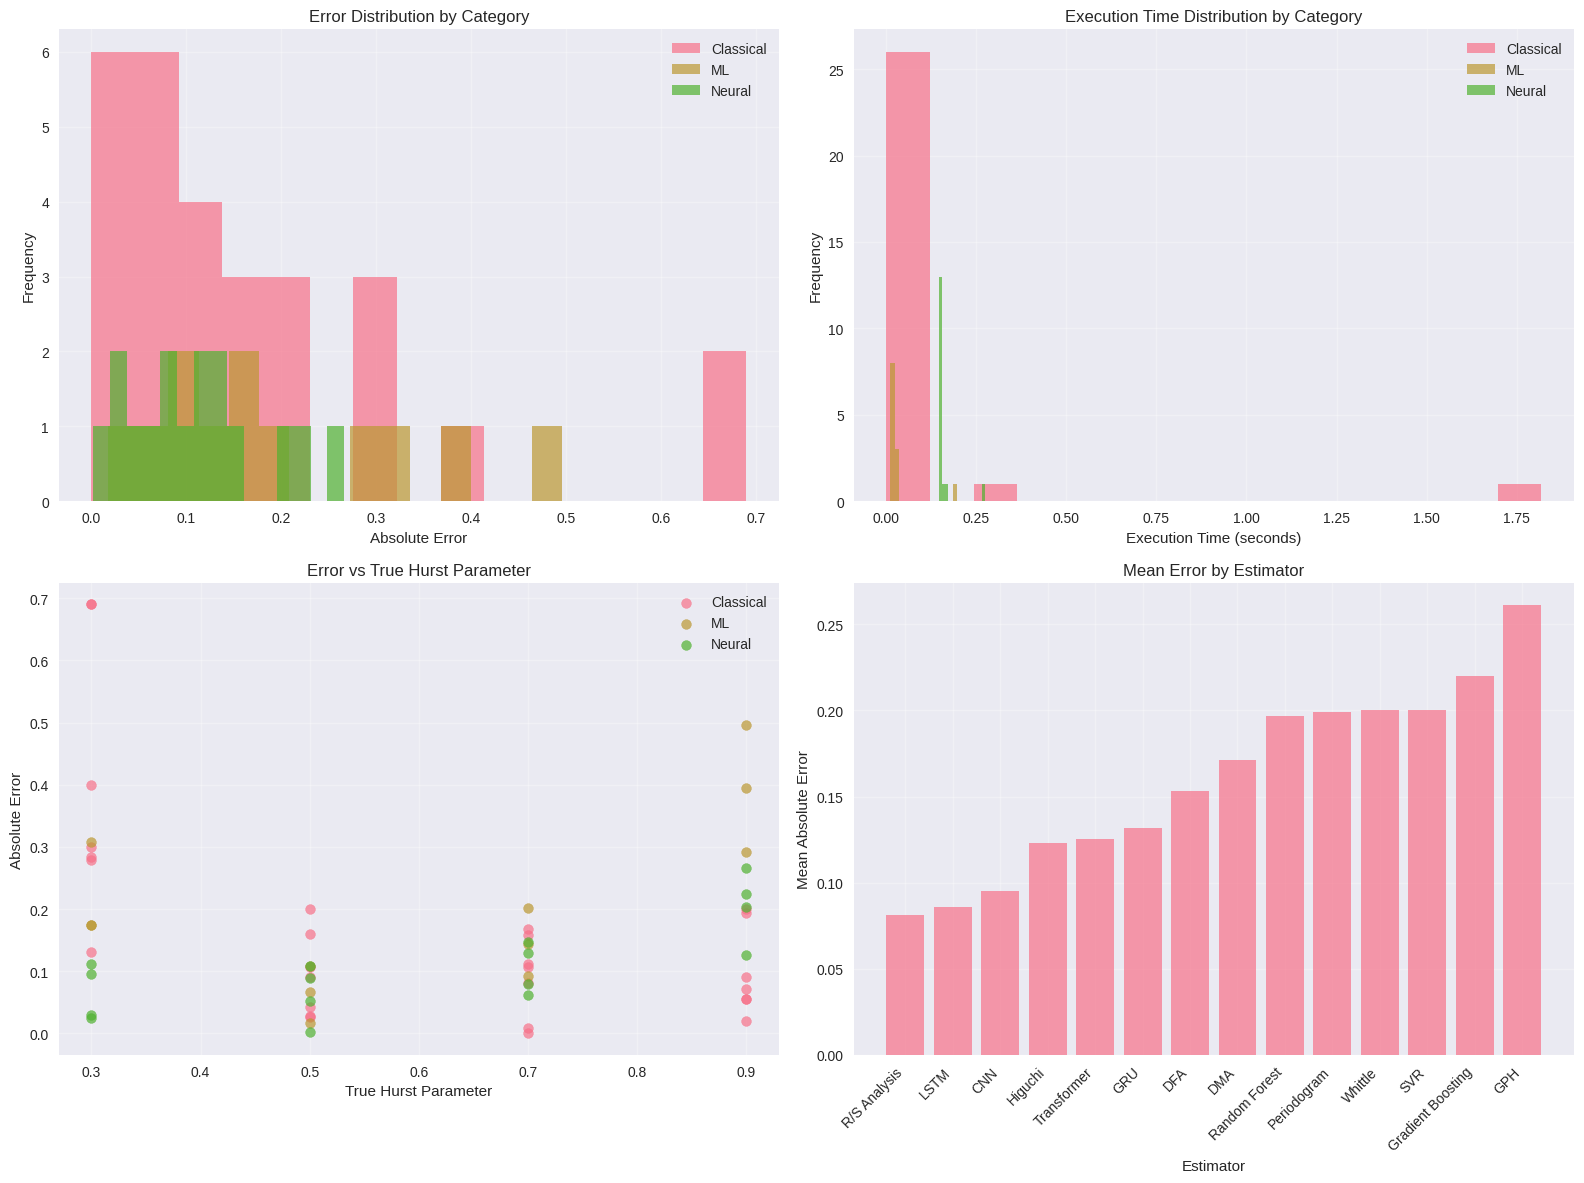


📊 Performance Summary by Category:
            Error                         Execution_Time        
             mean     std     min     max           mean     std
Category                                                        
Classical  0.1697  0.1766  0.0000  0.6900         0.0796  0.3449
ML         0.2057  0.1416  0.0174  0.4955         0.0317  0.0525
Neural     0.1095  0.0734  0.0021  0.2662         0.1598  0.0312

🏆 Top 5 Best Performing Estimators (by mean error):
  1. R/S Analysis: 0.0810
  2. LSTM: 0.0857
  3. CNN: 0.0951
  4. Higuchi: 0.1228
  5. Transformer: 0.1256

💾 Results saved to outputs/estimator_results.csv


In [5]:
# Create comprehensive performance comparison
if len(results_df) > 0:
    print("📊 Creating performance comparison visualizations...")
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Error distribution by category
    ax1 = axes[0, 0]
    for category in results_df['Category'].unique():
        category_data = results_df[results_df['Category'] == category]['Error']
        ax1.hist(category_data, alpha=0.7, label=category, bins=15)
    ax1.set_xlabel('Absolute Error')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Error Distribution by Category')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Execution time by category
    ax2 = axes[0, 1]
    for category in results_df['Category'].unique():
        category_data = results_df[results_df['Category'] == category]['Execution_Time']
        ax2.hist(category_data, alpha=0.7, label=category, bins=15)
    ax2.set_xlabel('Execution Time (seconds)')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Execution Time Distribution by Category')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Error vs True H
    ax3 = axes[1, 0]
    for category in results_df['Category'].unique():
        category_data = results_df[results_df['Category'] == category]
        ax3.scatter(category_data['True_H'], category_data['Error'], 
                   alpha=0.7, label=category, s=50)
    ax3.set_xlabel('True Hurst Parameter')
    ax3.set_ylabel('Absolute Error')
    ax3.set_title('Error vs True Hurst Parameter')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Performance summary by estimator
    ax4 = axes[1, 1]
    performance_by_estimator = results_df.groupby('Estimator')['Error'].mean().sort_values()
    ax4.bar(range(len(performance_by_estimator)), performance_by_estimator.values, alpha=0.7)
    ax4.set_xlabel('Estimator')
    ax4.set_ylabel('Mean Absolute Error')
    ax4.set_title('Mean Error by Estimator')
    ax4.set_xticks(range(len(performance_by_estimator)))
    ax4.set_xticklabels(performance_by_estimator.index, rotation=45, ha='right')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('outputs/estimator_performance_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Performance summary table
    print("\n📊 Performance Summary by Category:")
    category_summary = results_df.groupby('Category').agg({
        'Error': ['mean', 'std', 'min', 'max'],
        'Execution_Time': ['mean', 'std']
    }).round(4)
    print(category_summary)
    
    # Best performing estimators
    print("\n🏆 Top 5 Best Performing Estimators (by mean error):")
    best_estimators = results_df.groupby('Estimator')['Error'].mean().sort_values().head()
    for i, (estimator, error) in enumerate(best_estimators.items(), 1):
        print(f"  {i}. {estimator}: {error:.4f}")
    
    # Save results
    results_df.to_csv('outputs/estimator_results.csv', index=False)
    print("\n💾 Results saved to outputs/estimator_results.csv")
else:
    print("❌ No successful estimations to compare")


## 7. Decision Guidelines {#guidelines}

### When to Use Which Estimator

#### Classical Estimators
- **Best for**: Standard LRD processes, interpretable results, fast computation
- **Use when**: You need theoretical guarantees, have clean data, want fast results
- **Recommended**: R/S Analysis, DFA, GPH for most applications

#### Machine Learning Estimators
- **Best for**: Complex patterns, non-standard LRD processes, pre-trained models
- **Use when**: You have diverse data types, need robust estimation, have computational resources
- **Recommended**: Random Forest for general use, SVR for smooth patterns

#### Neural Network Estimators
- **Best for**: High-dimensional data, complex non-linear patterns, large datasets
- **Use when**: You have sufficient data, need state-of-the-art accuracy, can afford training time
- **Recommended**: CNN for spatial patterns, LSTM for temporal sequences, Transformer for attention-based patterns

### Performance Trade-offs

1. **Accuracy vs Speed**: Classical < ML < Neural (generally)
2. **Interpretability**: Classical > ML > Neural
3. **Robustness**: Depends on data quality and estimator choice
4. **Computational Requirements**: Classical < ML < Neural


## 8. Summary and Next Steps {#summary}

### Key Takeaways

1. **Estimator Diversity**: LRDBenchmark provides comprehensive coverage across three categories:
   - **Classical**: Fast, interpretable, theoretically grounded
   - **Machine Learning**: Robust, flexible, pre-trained models
   - **Neural Networks**: High accuracy, complex patterns, state-of-the-art

2. **Performance Characteristics**:
   - Classical estimators are fastest and most interpretable
   - ML estimators provide good balance of accuracy and robustness
   - Neural networks offer highest accuracy for complex patterns

3. **Selection Guidelines**:
   - Use classical estimators for standard LRD analysis
   - Use ML estimators for diverse data types and robustness
   - Use neural networks for complex patterns and high accuracy requirements

### Next Steps

1. **Benchmarking**: Compare estimators systematically across different data types
2. **Custom Estimators**: Learn how to extend the library with custom estimators
3. **Real-world Application**: Apply estimators to actual time series data
4. **Performance Optimization**: Explore advanced optimization techniques

### Files Generated

- `outputs/estimator_performance_comparison.png`: Comprehensive performance visualization
- `outputs/estimator_results.csv`: Detailed results table
- Performance metrics and rankings

### References

1. Hurst, H. E. (1951). Long-term storage capacity of reservoirs. Transactions of the American Society of Civil Engineers, 116(1), 770-808.
2. Peng, C. K., et al. (1994). Mosaic organization of DNA nucleotides. Physical review E, 49(2), 1685.
3. Geweke, J., & Porter-Hudak, S. (1983). The estimation and application of long memory time series models. Journal of time series analysis, 4(4), 221-238.
4. Abry, P., & Veitch, D. (1998). Wavelet analysis of long-range-dependent traffic. IEEE Transactions on information theory, 44(1), 2-15.

---

**Next Notebook**: [03_custom_models_and_estimators.ipynb](03_custom_models_and_estimators.ipynb) - Learn how to extend the library with custom data models and estimators.
